In [1]:
import warnings 
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Conv1D, GlobalMaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import json

2024-04-26 19:30:41.317904: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 19:30:41.318015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 19:30:41.443437: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### Check if GPU is available or not

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("GPU is not available, using CPU instead.")

Using GPU: /physical_device:GPU:0


#### Loading a file with preprocessed purchase sequences of users with at least 3 purchased products

In [3]:
with open('/kaggle/input/users-sequences/users_sequences.json', 'r') as file:
    users_sequences = json.load(file)

print('Number of users/sequences in total:', len(users_sequences))

Number of users/sequences in total: 601263


In [4]:
parameters = {}
parameters['number_of_users_in_total'] = len(users_sequences)
parameters['number_of_sequences_in_total'] = len(users_sequences)

#### Filtering sequences in which at least min_num_of_products_in_sequence of products were purchased, i.e. users who purchased at least min_num_of_products_in_sequence of products

In [5]:
min_num_of_products_in_sequence = 5
filtered_users_sequences = {}

for key, value in users_sequences.items():
    if len(value) >= min_num_of_products_in_sequence:
        filtered_users_sequences[key] = value

print('Number of users/sequences after filtering:', len(filtered_users_sequences))

Number of users/sequences after filtering: 252156


In [6]:
parameters['number_of_sequences_after_filtering'] = len(filtered_users_sequences)
parameters['number_of_users_after_filtering'] = len(filtered_users_sequences)

#### Creating sequences of length sequence_length and splitting the sequences into train, validation and test datasets, so that the last sequence is selected into the test dataset, the penultimate sequence is selected into the validation dataset and all previous ones are selected into the train dataset. Padding with a value of 0 is applied to keep the sequence length equal to sequence_length

In [7]:
sequence_length = 7

def generate_and_split_sequences(data):
    train_sequences = []
    validation_sequences = []
    test_sequences = []
    train_targets = []
    validation_targets = []
    test_targets = []
    train_user_ids = []
    validation_user_ids = []
    test_user_ids = []

    for user_id, products in data.items():
        n = len(products)
        if n < 2:
            continue

        sequences = []
        for i in range(1, n):
            current_seq = products[:i]
            if len(current_seq) < sequence_length:
                padded_seq = [0] * (sequence_length - len(current_seq)) + current_seq
                sequences.append(padded_seq)
            else:
                sequences.append(current_seq[-sequence_length:])

        targets = products[1:]

        if len(sequences) >= 2:
            train_sequences.extend(sequences[:-2])
            train_targets.extend(targets[:-2])
            train_user_ids.extend([user_id] * (len(sequences) - 2))

            validation_sequences.append(sequences[-2])
            validation_targets.append(targets[-2])
            validation_user_ids.append(user_id)

            test_sequences.append(sequences[-1])
            test_targets.append(targets[-1])
            test_user_ids.append(user_id)
        elif len(sequences) == 1:
            test_sequences.append(sequences[0])
            test_targets.append(targets[0])
            test_user_ids.append(user_id)

    return {
        'train': (train_sequences, train_targets, train_user_ids),
        'validation': (validation_sequences, validation_targets, validation_user_ids),
        'test': (test_sequences, test_targets, test_user_ids)
    }

datasets = generate_and_split_sequences(filtered_users_sequences)

In [8]:
parameters['sequence_length'] = sequence_length

#### Assigning obtained datasets to a clearer form

In [9]:
X_train = datasets['train'][0]
y_train = datasets['train'][1]

X_val = datasets['validation'][0]
y_val = datasets['validation'][1]

X_test = datasets['test'][0]
y_test = datasets['test'][1]

print("An example of what sequences and targets look like:\n\nSequences:\n", X_train[-10:])
print("\nTargets:\n", y_train[-10:])

An example of what sequences and targets look like:

Sequences:
 [[0, 0, 0, 0, 0, 0, 12441], [0, 0, 0, 0, 0, 12441, 47820], [0, 0, 0, 0, 12441, 47820, 114530], [0, 0, 0, 12441, 47820, 114530, 86657], [0, 0, 12441, 47820, 114530, 86657, 39579], [0, 0, 0, 0, 0, 0, 11424], [0, 0, 0, 0, 0, 11424, 5089], [0, 0, 0, 0, 11424, 5089, 108533], [0, 0, 0, 11424, 5089, 108533, 108535], [0, 0, 11424, 5089, 108533, 108535, 22344]]

Targets:
 [47820, 114530, 86657, 39579, 91113, 5089, 108533, 108535, 22344, 18742]


In [10]:
print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

Number of train sequences: 1489192
Number of validation sequences: 252156
Number of test sequences: 252156

Number of train targets: 1489192
Number of validation targets: 252156
Number of test targets: 252156


In [11]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

#### Preprocessing datasets for faster processing

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [13]:
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [14]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

-------

### Defining metrics

#### F1@k

In [15]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [16]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [17]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

#### Getting the highest product ID value for input_dim in Embedding layers

In [18]:
max_product_id = float('-inf')

for user, sequences in filtered_users_sequences.items():
    current_max = max(sequences)
    if current_max > max_product_id:
        max_product_id = current_max

max_product_id

144605

-------

# Training and evaluating models

## LSTM

In [20]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_lstm.add(LSTM(32, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(max_product_id, activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [21]:
history_model_lstm = model_lstm.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
   14/23269 ━━━━━━━━━━━━━━━━━━━━ 3:19 9ms/step - accuracy: 0.0016 - f1_score_at_k: 0.0031 - hit_rate_at_k: 0.0048 - loss: 11.8809 - ndcg_at_k: 0.0010                   

I0000 00:00:1714143303.886689      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23269/23269 ━━━━━━━━━━━━━━━━━━━━ 216s 9ms/step - accuracy: 0.0335 - f1_score_at_k: 0.0290 - hit_rate_at_k: 0.0573 - loss: 9.6799 - ndcg_at_k: 0.0156 - val_accuracy: 0.0515 - val_f1_score_at_k: 0.0590 - val_hit_rate_at_k: 0.0724 - val_loss: 9.5876 - val_ndcg_at_k: 0.0214
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 196s 8ms/step - accuracy: 0.0572 - f1_score_at_k: 0.0615 - hit_rate_at_k: 0.0891 - loss: 9.0269 - ndcg_at_k: 0.0251 - val_accuracy: 0.0659 - val_f1_score_at_k: 0.0684 - val_hit_rate_at_k: 0.0840 - val_loss: 9.4550 - val_ndcg_at_k: 0.0256
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 196s 8ms/step - accuracy: 0.0676 - f1_score_at_k: 0.0705 - hit_rate_at_k: 0.0991 - loss: 8.8493 - ndcg_at_k: 0.0286 - val_accuracy: 0.0711 - val_f1_score_at_k: 0.0728 - val_hit_rate_at_k: 0.0888 - val_loss: 9.4205 - val_ndcg_at_k: 0.0273
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 195s 8ms/step - accuracy: 0.0726 - f1_score_at_k: 0.0757 - hit_rate_at_k: 0.1044 - loss: 8.7630 - ndcg_at_k: 0.0303 - val

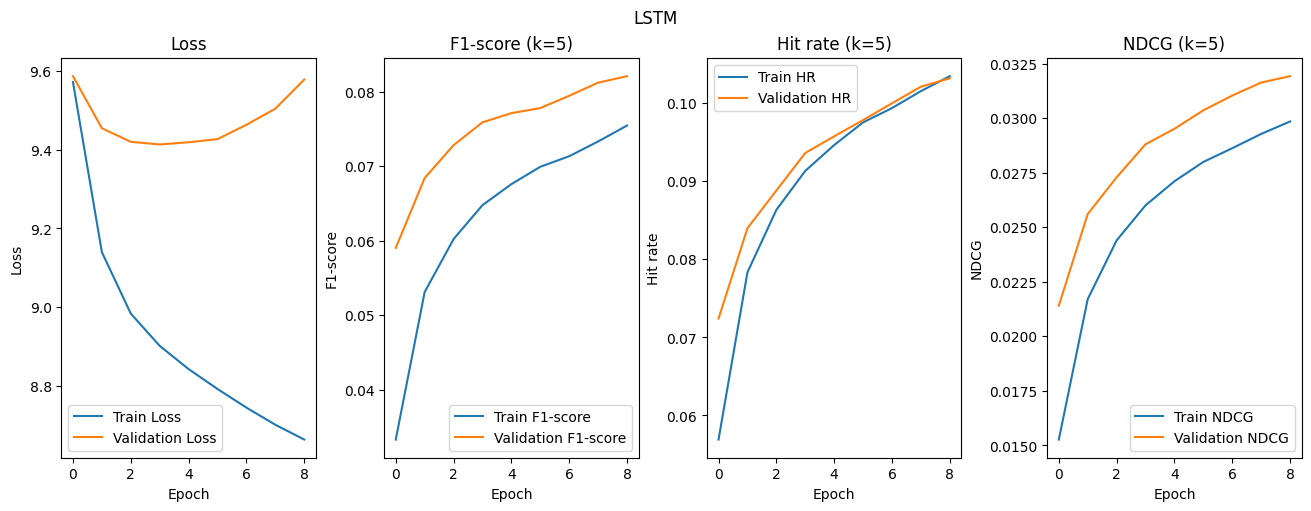

In [22]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_lstm.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_lstm.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('LSTM')
plt.show()

In [23]:
model_lstm_test_loss, model_lstm_test_accuracy, model_lstm_test_f1_score, model_lstm_test_hr, model_lstm_test_ndcg = model_lstm.evaluate(test_dataset)

print("Test loss:", round(model_lstm_test_loss, 4))
print("Test accuracy:", round(model_lstm_test_accuracy, 4))
print("Test F1@5:", round(model_lstm_test_f1_score, 4))
print("Test HR@5:", round(model_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_lstm_test_ndcg, 4))

parameters["model_lstm_test_loss"] = model_lstm_test_loss
parameters["model_lstm_test_accuracy"] = round(model_lstm_test_accuracy, 4)
parameters["model_lstm_test_f1_score"] = round(model_lstm_test_f1_score, 4)
parameters["model_lstm_test_hr"] = round(model_lstm_test_hr, 4)
parameters["model_lstm_test_ndcg"] = round(model_lstm_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.0765 - f1_score_at_k: 0.0769 - hit_rate_at_k: 0.0923 - loss: nan - ndcg_at_k: 0.0288
Test loss: nan
Test accuracy: 0.0611
Test F1@5: 0.0626
Test HR@5: 0.0763
Test NDCG@5: 0.0234


In [24]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 7,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_lstm_test_loss': nan,
 'model_lstm_test_accuracy': 0.0611,
 'model_lstm_test_f1_score': 0.0626,
 'model_lstm_test_hr': 0.0763,
 'model_lstm_test_ndcg': 0.0234}

---------

## Bidirectional-LSTM

In [32]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(max_product_id, activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [33]:
history_model_bi_lstm = model_bi_lstm.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 272s 11ms/step - accuracy: 0.0394 - f1_score_at_k: 0.0352 - hit_rate_at_k: 0.0635 - loss: 9.6281 - ndcg_at_k: 0.0176 - val_accuracy: 0.0605 - val_f1_score_at_k: 0.0618 - val_hit_rate_at_k: 0.0753 - val_loss: 9.4794 - val_ndcg_at_k: 0.0232
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 301s 10ms/step - accuracy: 0.0656 - f1_score_at_k: 0.0677 - hit_rate_at_k: 0.0954 - loss: 8.9320 - ndcg_at_k: 0.0276 - val_accuracy: 0.0716 - val_f1_score_at_k: 0.0708 - val_hit_rate_at_k: 0.0862 - val_loss: 9.3843 - val_ndcg_at_k: 0.0269
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 244s 10ms/step - accuracy: 0.0768 - f1_score_at_k: 0.0766 - hit_rate_at_k: 0.1057 - loss: 8.7630 - ndcg_at_k: 0.0312 - val_accuracy: 0.0767 - val_f1_score_at_k: 0.0761 - val_hit_rate_at_k: 0.0933 - val_loss: 9.3395 - val_ndcg_at_k: 0.0290
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 248s 11ms/step - accuracy: 0.0839 - f1_score_at_k: 0.0827 - hit_rate_at_k: 0.1124 - loss: 8.6528 - ndcg_at_

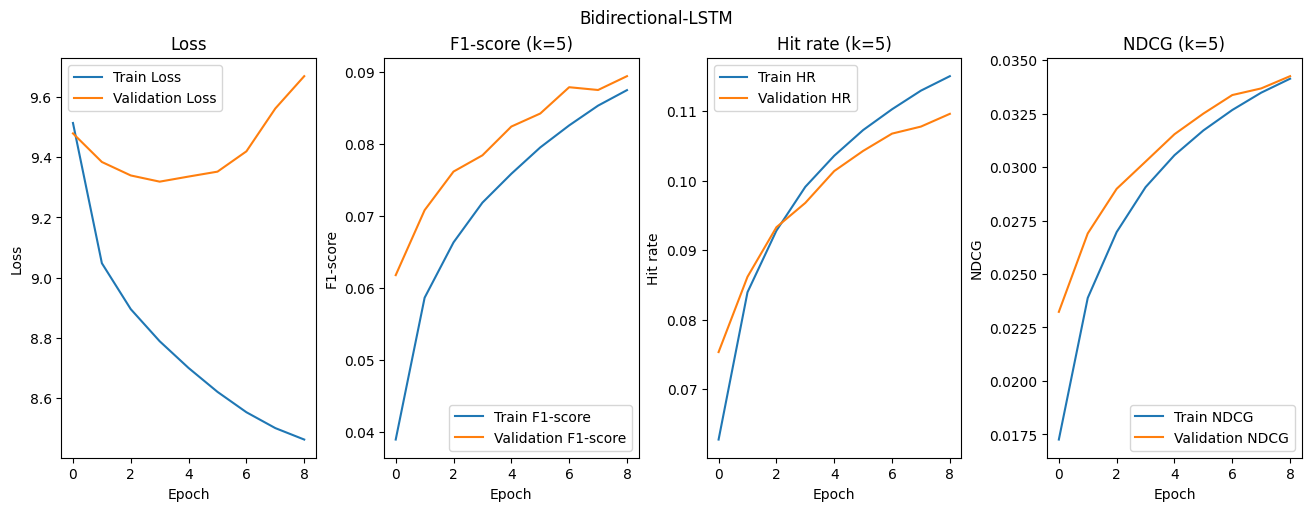

In [34]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_bi_lstm.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_bi_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_bi_lstm.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_bi_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [35]:
model_bi_lstm_test_loss, model_bi_lstm_test_accuracy, model_bi_lstm_test_f1_score, model_bi_lstm_test_hr, model_bi_lstm_test_ndcg = model_bi_lstm.evaluate(test_dataset)

print("Test loss:", round(model_bi_lstm_test_loss, 4))
print("Test accuracy:", round(model_bi_lstm_test_accuracy, 4))
print("Test F1@5:", round(model_bi_lstm_test_f1_score, 4))
print("Test HR@5:", round(model_bi_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_bi_lstm_test_ndcg, 4))

parameters["model_bi_lstm_test_loss"] = model_bi_lstm_test_loss
parameters["model_bi_lstm_test_accuracy"] = round(model_bi_lstm_test_accuracy, 4)
parameters["model_bi_lstm_test_f1_score"] = round(model_bi_lstm_test_f1_score, 4)
parameters["model_bi_lstm_test_hr"] = round(model_bi_lstm_test_hr, 4)
parameters["model_bi_lstm_test_ndcg"] = round(model_bi_lstm_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.0845 - f1_score_at_k: 0.0832 - hit_rate_at_k: 0.0982 - loss: nan - ndcg_at_k: 0.0311
Test loss: nan
Test accuracy: 0.0685
Test F1@5: 0.0681
Test HR@5: 0.0816
Test NDCG@5: 0.0255


In [36]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 7,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_lstm_test_loss': nan,
 'model_lstm_test_accuracy': 0.0611,
 'model_lstm_test_f1_score': 0.0626,
 'model_lstm_test_hr': 0.0763,
 'model_lstm_test_ndcg': 0.0234,
 'model_bi_lstm_test_loss': nan,
 'model_bi_lstm_test_accuracy': 0.0685,
 'model_bi_lstm_test_f1_score': 0.0681,
 'model_bi_lstm_test_hr': 0.0816,
 'model_bi_lstm_test_ndcg': 0.0255}

-----------

## GRU

In [37]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_gru.add(GRU(32, activation='relu', return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(max_product_id, activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [38]:
history_model_gru = model_gru.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 224s 9ms/step - accuracy: 0.0350 - f1_score_at_k: 0.0290 - hit_rate_at_k: 0.0588 - loss: 9.6816 - ndcg_at_k: 0.0161 - val_accuracy: 0.0505 - val_f1_score_at_k: 0.0568 - val_hit_rate_at_k: 0.0711 - val_loss: 9.6216 - val_ndcg_at_k: 0.0209
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 246s 9ms/step - accuracy: 0.0527 - f1_score_at_k: 0.0563 - hit_rate_at_k: 0.0839 - loss: 9.0956 - ndcg_at_k: 0.0234 - val_accuracy: 0.0593 - val_f1_score_at_k: 0.0659 - val_hit_rate_at_k: 0.0826 - val_loss: 9.4919 - val_ndcg_at_k: 0.0244
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 203s 9ms/step - accuracy: 0.0615 - f1_score_at_k: 0.0660 - hit_rate_at_k: 0.0954 - loss: 8.8978 - ndcg_at_k: 0.0269 - val_accuracy: 0.0662 - val_f1_score_at_k: 0.0708 - val_hit_rate_at_k: 0.0886 - val_loss: 9.4271 - val_ndcg_at_k: 0.0265
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 203s 9ms/step - accuracy: 0.0667 - f1_score_at_k: 0.0719 - hit_rate_at_k: 0.1017 - loss: 8.8005 - ndcg_at_k: 0

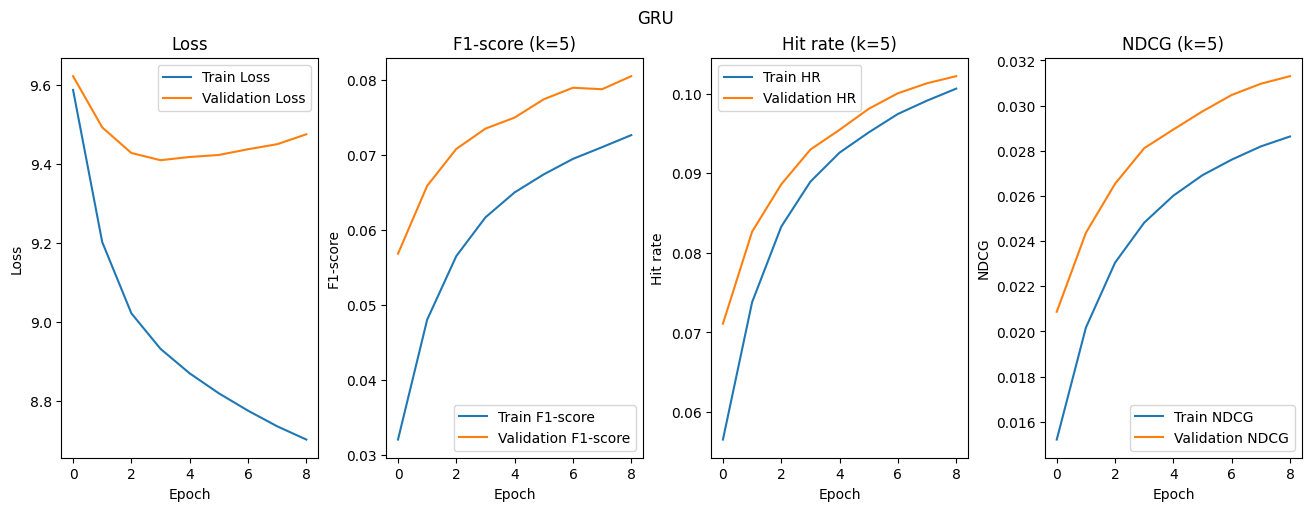

In [42]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_gru.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_gru.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_gru.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_gru.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('GRU')
plt.show()

In [43]:
model_gru_test_loss, model_gru_test_accuracy, model_gru_test_f1_score, model_gru_test_hr, model_gru_test_ndcg = model_gru.evaluate(test_dataset)

print("Test loss:", round(model_gru_test_loss, 4))
print("Test accuracy:", round(model_gru_test_accuracy, 4))
print("Test F1@5:", round(model_gru_test_f1_score, 4))
print("Test HR@5:", round(model_gru_test_hr, 4))
print("Test NDCG@5:", round(model_gru_test_ndcg, 4))

parameters["model_gru_test_loss"] = model_gru_test_loss
parameters["model_gru_test_accuracy"] = round(model_gru_test_accuracy, 4)
parameters["model_gru_test_f1_score"] = round(model_gru_test_f1_score, 4)
parameters["model_gru_test_hr"] = round(model_gru_test_hr, 4)
parameters["model_gru_test_ndcg"] = round(model_gru_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.0726 - f1_score_at_k: 0.0744 - hit_rate_at_k: 0.0912 - loss: nan - ndcg_at_k: 0.0280
Test loss: nan
Test accuracy: 0.058
Test F1@5: 0.0607
Test HR@5: 0.0755
Test NDCG@5: 0.0228


In [44]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 7,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_lstm_test_loss': nan,
 'model_lstm_test_accuracy': 0.0611,
 'model_lstm_test_f1_score': 0.0626,
 'model_lstm_test_hr': 0.0763,
 'model_lstm_test_ndcg': 0.0234,
 'model_bi_lstm_test_loss': nan,
 'model_bi_lstm_test_accuracy': 0.0685,
 'model_bi_lstm_test_f1_score': 0.0681,
 'model_bi_lstm_test_hr': 0.0816,
 'model_bi_lstm_test_ndcg': 0.0255,
 'model_gru_test_loss': nan,
 'model_gru_test_accuracy': 0.058,
 'model_gru_test_f1_score': 0.0607,
 'model_gru_test_hr': 0.0755,
 'model_gru_test_ndcg': 0.0228}

--------

## Autoencoder

In [19]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(max_product_id, activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [20]:
history_model_autoencoder = model_autoencoder.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
   12/23269 ━━━━━━━━━━━━━━━━━━━━ 3:49 10ms/step - accuracy: 1.0851e-04 - f1_score_at_k: 7.2338e-05 - hit_rate_at_k: 1.0851e-04 - loss: 11.8818 - ndcg_at_k: 3.6801e-05  

I0000 00:00:1714159963.750867      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23269/23269 ━━━━━━━━━━━━━━━━━━━━ 241s 10ms/step - accuracy: 0.0251 - f1_score_at_k: 0.0180 - hit_rate_at_k: 0.0466 - loss: 9.8029 - ndcg_at_k: 0.0123 - val_accuracy: 0.0375 - val_f1_score_at_k: 0.0487 - val_hit_rate_at_k: 0.0634 - val_loss: 9.4436 - val_ndcg_at_k: 0.0174
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 218s 9ms/step - accuracy: 0.0418 - f1_score_at_k: 0.0446 - hit_rate_at_k: 0.0761 - loss: 8.9796 - ndcg_at_k: 0.0202 - val_accuracy: 0.0528 - val_f1_score_at_k: 0.0623 - val_hit_rate_at_k: 0.0789 - val_loss: 9.3455 - val_ndcg_at_k: 0.0225
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 217s 9ms/step - accuracy: 0.0502 - f1_score_at_k: 0.0571 - hit_rate_at_k: 0.0886 - loss: 8.8717 - ndcg_at_k: 0.0238 - val_accuracy: 0.0576 - val_f1_score_at_k: 0.0695 - val_hit_rate_at_k: 0.0868 - val_loss: 9.3705 - val_ndcg_at_k: 0.0247
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 217s 9ms/step - accuracy: 0.0548 - f1_score_at_k: 0.0625 - hit_rate_at_k: 0.0947 - loss: 8.8180 - ndcg_at_k: 0.0257 - va

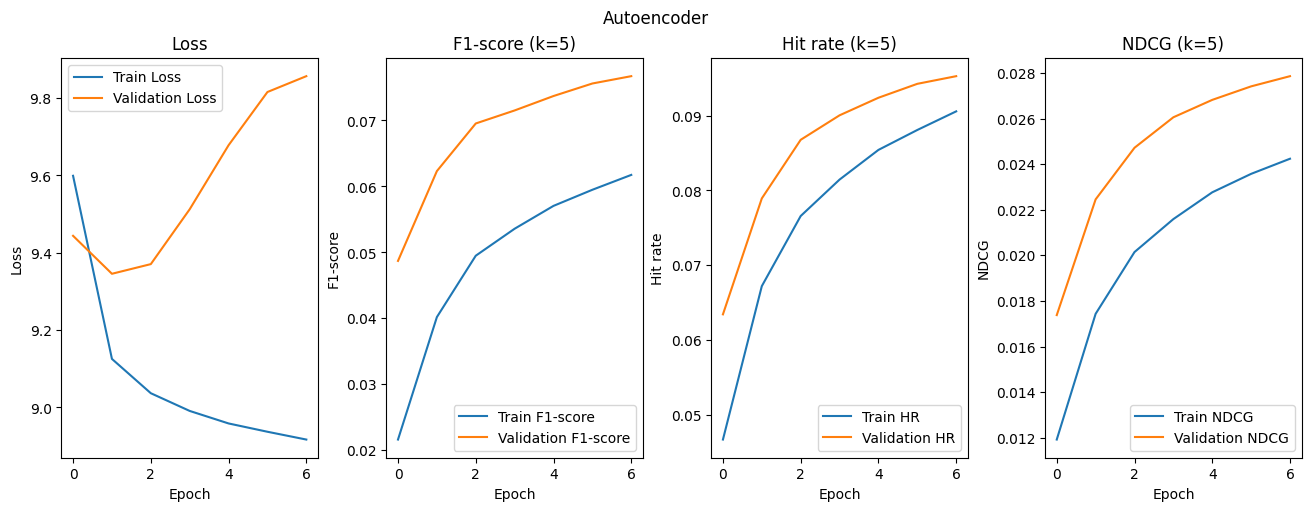

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_autoencoder.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_autoencoder.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_autoencoder.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_autoencoder.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('Autoencoder')
plt.show()

In [22]:
model_autoencoder_test_loss, model_autoencoder_test_accuracy, model_autoencoder_test_f1_score, model_autoencoder_test_hr, model_autoencoder_test_ndcg = model_autoencoder.evaluate(test_dataset)

print("Test loss:", round(model_autoencoder_test_loss, 4))
print("Test accuracy:", round(model_autoencoder_test_accuracy, 4))
print("Test F1@5:", round(model_autoencoder_test_f1_score, 4))
print("Test HR@5:", round(model_autoencoder_test_hr, 4))
print("Test NDCG@5:", round(model_autoencoder_test_ndcg, 4))

parameters["model_autoencoder_test_loss"] = model_autoencoder_test_loss
parameters["model_autoencoder_test_accuracy"] = round(model_autoencoder_test_accuracy, 4)
parameters["model_autoencoder_test_f1_score"] = round(model_autoencoder_test_f1_score, 4)
parameters["model_autoencoder_test_hr"] = round(model_autoencoder_test_hr, 4)
parameters["model_autoencoder_test_ndcg"] = round(model_autoencoder_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.0609 - f1_score_at_k: 0.0725 - hit_rate_at_k: 0.0846 - loss: nan - ndcg_at_k: 0.0249
Test loss: nan
Test accuracy: 0.0472
Test F1@5: 0.0574
Test HR@5: 0.0687
Test NDCG@5: 0.0199


In [23]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 7,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_autoencoder_test_loss': nan,
 'model_autoencoder_test_accuracy': 0.0472,
 'model_autoencoder_test_f1_score': 0.0574,
 'model_autoencoder_test_hr': 0.0687,
 'model_autoencoder_test_ndcg': 0.0199}

-------

## CNN

In [24]:
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=max_product_id, output_dim=50, mask_zero=True))
model_cnn.add(Conv1D(64, 3, activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.2))
#model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(64, 3, activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.2))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dense(max_product_id, activation='softmax'))

model_cnn.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [25]:
history_model_cnn = model_cnn.fit(
    train_dataset,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 195s 8ms/step - accuracy: 0.0437 - f1_score_at_k: 0.0383 - hit_rate_at_k: 0.0660 - loss: 9.6050 - ndcg_at_k: 0.0188 - val_accuracy: 0.0583 - val_f1_score_at_k: 0.0596 - val_hit_rate_at_k: 0.0741 - val_loss: 9.6648 - val_ndcg_at_k: 0.0227
Epoch 2/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 180s 8ms/step - accuracy: 0.0675 - f1_score_at_k: 0.0660 - hit_rate_at_k: 0.0931 - loss: 9.0329 - ndcg_at_k: 0.0275 - val_accuracy: 0.0646 - val_f1_score_at_k: 0.0636 - val_hit_rate_at_k: 0.0802 - val_loss: 9.5169 - val_ndcg_at_k: 0.0247
Epoch 3/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 180s 8ms/step - accuracy: 0.0766 - f1_score_at_k: 0.0754 - hit_rate_at_k: 0.1032 - loss: 8.8313 - ndcg_at_k: 0.0308 - val_accuracy: 0.0714 - val_f1_score_at_k: 0.0707 - val_hit_rate_at_k: 0.0862 - val_loss: 9.5247 - val_ndcg_at_k: 0.0269
Epoch 4/25
23269/23269 ━━━━━━━━━━━━━━━━━━━━ 182s 8ms/step - accuracy: 0.0826 - f1_score_at_k: 0.0800 - hit_rate_at_k: 0.1091 - loss: 8.7194 - ndcg_at_k: 0

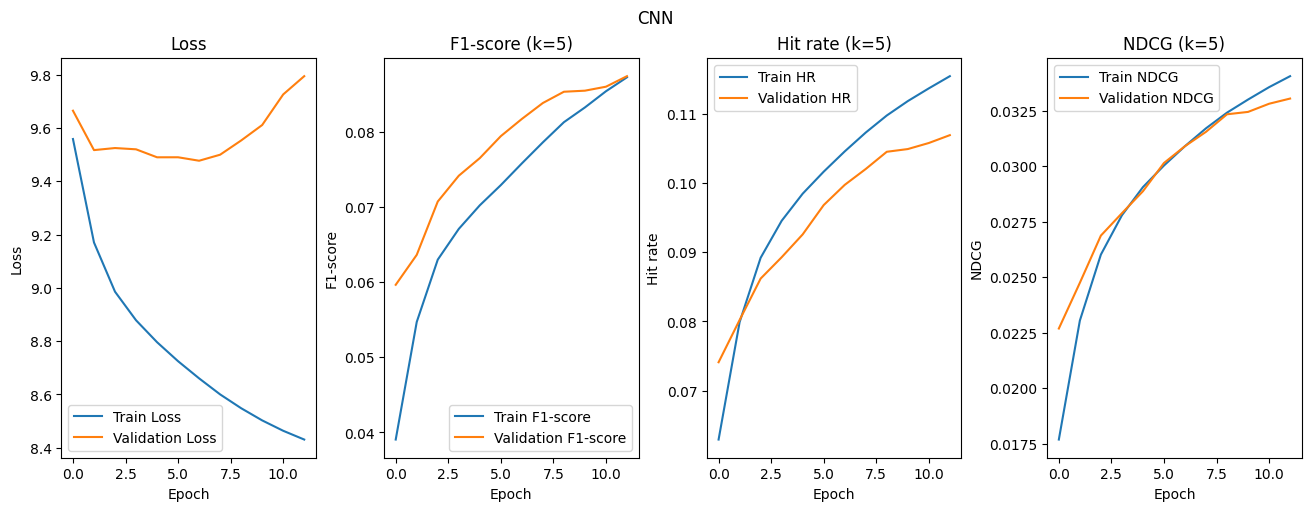

In [26]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_cnn.history['loss'], label='Train Loss')
ax1.plot(history_model_cnn.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_cnn.history['f1_score_at_k'], label='Train F1-score')
ax2.plot(history_model_cnn.history['val_f1_score_at_k'], label='Validation F1-score')
ax2.set_title('F1-score (k=5)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_cnn.history['hit_rate_at_k'], label='Train HR')
ax3.plot(history_model_cnn.history['val_hit_rate_at_k'], label='Validation HR')
ax3.set_title('Hit rate (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Hit rate')
ax3.legend()

ax4.plot(history_model_cnn.history['ndcg_at_k'], label='Train NDCG')
ax4.plot(history_model_cnn.history['val_ndcg_at_k'], label='Validation NDCG')
ax4.set_title('NDCG (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('NDCG')
ax4.legend()

plt.suptitle('CNN')
plt.show()

In [27]:
model_cnn_test_loss, model_cnn_test_accuracy, model_cnn_test_f1_score, model_cnn_test_hr, model_cnn_test_ndcg = model_cnn.evaluate(test_dataset)

print("Test loss:", round(model_cnn_test_loss, 4))
print("Test accuracy:", round(model_cnn_test_accuracy, 4))
print("Test F1@5:", round(model_cnn_test_f1_score, 4))
print("Test HR@5:", round(model_cnn_test_hr, 4))
print("Test NDCG@5:", round(model_cnn_test_ndcg, 4))

parameters["model_cnn_test_loss"] = model_cnn_test_loss
parameters["model_cnn_test_accuracy"] = round(model_cnn_test_accuracy, 4)
parameters["model_cnn_test_f1_score"] = round(model_cnn_test_f1_score, 4)
parameters["model_cnn_test_hr"] = round(model_cnn_test_hr, 4)
parameters["model_cnn_test_ndcg"] = round(model_cnn_test_ndcg, 4)

3940/3940 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.0809 - f1_score_at_k: 0.0817 - hit_rate_at_k: 0.0976 - loss: nan - ndcg_at_k: 0.0304
Test loss: nan
Test accuracy: 0.0641
Test F1@5: 0.0658
Test HR@5: 0.0798
Test NDCG@5: 0.0246


------

In [29]:
parameters

{'number_of_users_in_total': 601263,
 'number_of_sequences_in_total': 601263,
 'number_of_sequences_after_filtering': 252156,
 'number_of_users_after_filtering': 252156,
 'sequence_length': 7,
 'number_of_sequences_and_targets_train': 1489192,
 'number_of_sequences_and_targets_validation': 252156,
 'number_of_sequences_and_targets_test': 252156,
 'model_autoencoder_test_loss': nan,
 'model_autoencoder_test_accuracy': 0.0472,
 'model_autoencoder_test_f1_score': 0.0574,
 'model_autoencoder_test_hr': 0.0687,
 'model_autoencoder_test_ndcg': 0.0199,
 'model_cnn_test_loss': nan,
 'model_cnn_test_accuracy': 0.0641,
 'model_cnn_test_f1_score': 0.0658,
 'model_cnn_test_hr': 0.0798,
 'model_cnn_test_ndcg': 0.0246}